In [1]:
# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 14

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.CustomGraph(edge_colors)

In [4]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [5]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, graph=g)

In [6]:
# Custom Hamiltonian operator
op = nk.operator.GraphOperator(hi, bondops=bond_operator, bondops_colors=bond_color)

In [7]:
# Define the fully-connected FFNN
layers = (nk.layer.FullyConnected(input_size=L,output_size=2*L,use_bias=True),
          nk.layer.Lncosh(input_size=2*L),
          nk.layer.SumOutput(input_size=2*L))
for layer in layers:
    layer.init_random_parameters(seed=1234, sigma=0.01)

ffnn = nk.machine.FFNN(hi, layers)

In [8]:
# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(graph=g, machine=ffnn, d_max = 2)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# We can then specify a Variational Monte Carlo object, using the Hamiltonian, sampler and optimizers chosen.
# Note that we also specify the method to learn the parameters of the wave-function: here we choose the efficient
# Stochastic reconfiguration (Sr), here in an iterative setup
gs = nk.variational.Vmc(hamiltonian=op,
                        sampler=sa,
                        optimizer=opt,
                        n_samples=1000,
                        use_iterative=True,
                        method='Sr')


In [9]:
# We need to specify the local operators as a matrix acting on a local Hilbert space
sf = []
sites = []
for i in range(0, L):
    for j in range(0, L):
        sf.append(((-1)**(i-j)*mszsz/L).tolist())
        sites.append([i,j])
structure_factor = nk.operator.LocalOperator(hi, sf, sites)

# Add the observable to the VMC object
gs.add_observable(structure_factor, "Structure Factor")


In [10]:
# Run the optimization protocol
gs.run(output_prefix='test', n_iter=600)


In [11]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

# Extract the relevant information

iters=[]
energy=[]
sf=[]

for iteration in data["Output"]:
    iters.append(iteration["Iteration"])
    energy.append(iteration["Energy"]["Mean"])
    sf.append(iteration["Structure Factor"]["Mean"])


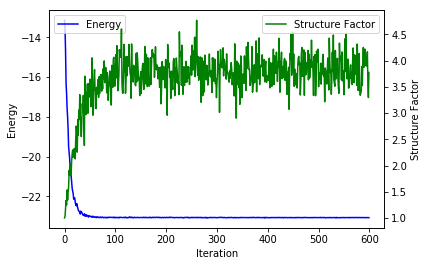

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx()
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()


In [14]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 3.814(0.042)
Energy = -23.062(0.001)


In [15]:
res = nk.exact.lanczos_ed(op, first_n=1, compute_eigenvectors=True)

In [16]:
print("Exact Ground-state Structure Factor: {0:.3f}".format(np.real(res.mean(structure_factor, 0))))
print("Exact ground state energy = {0:.3f}".format(res.eigenvalues[0]))

Exact Ground-state Structure Factor: 3.803
Exact ground state energy = -23.064
